## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from threading import Thread
from matplotlib.animation import FuncAnimation
from http.server import HTTPServer, BaseHTTPRequestHandler
import json
from time import sleep
import os
import glob
import datetime
import scipy.stats as stats



In [2]:
def time_fixer(df):
    df['time'] = pd.to_datetime(df['time'], unit='ns')
    df['time'] = df['time'] + pd.Timedelta(hours= 2)
    return df

In [3]:
def plotter(df, type):

    if type == 'acc' or type == 'gyro' or type == 'mag':
        plt.figure(figsize=(25,10))
        plt.plot(df['time'], df.x, label='x')
        plt.plot(df['time'], df.y, label='y')
        plt.plot(df['time'], df.z, label='z')
        plt.legend()
        plt.title(type)
        plt.show()
    elif type == 'orient':
        plt.figure(figsize=(25,10))
        plt.plot(df['time'], df.yaw, label='yaw')
        plt.plot(df['time'], df.pitch, label='pitch')
        plt.plot(df['time'], df.roll, label='roll')
        plt.legend()
        plt.title(type)
        plt.show()

In [4]:
def labeler(dataframe, lower_lim, upper_lim, label):
    """
    This function labels the data in the dataframe between two timestamps with the same label,
    For this funciton to work, the dataframer as well as the lower and upper limits for the timestamps and the label must be provided,
    The timestamp format must be a string and look like this: 'YYYY-MM-DD HH:MM:SS'
    """

    lower_lim = datetime.datetime.strptime(lower_lim, '%Y-%m-%d %H:%M:%S')
    upper_lim = datetime.datetime.strptime(upper_lim, '%Y-%m-%d %H:%M:%S')

    dataframe.loc[(dataframe['time'] > lower_lim) & (dataframe['time'] < upper_lim), 'label'] = label
    return dataframe

In [5]:
def segmenter(df, sampling_rate):
    """
    This funciton takes the dataframe and returns a new dataframe with the data segmented into 4 seconds intervals,
    The final dataframe will have the variance and the mean of each column in the dataframe as well as the label column for each segment
    The dataframe's length does not have to be divisible by 4, the last segment will be shorter than 4 seconds
    """
    # convert sampling rate to number of rows
    segmented_df = pd.DataFrame(columns=['start_time', 'end_time', 'roll_var', 'pitch_var', 'yaw_var', 'roll_mean', 'pitch_mean', 'yaw_mean', 'roll_std', 'ptich_std', 'yaw_std', 'label'])
    for i in range(0, len(df), sampling_rate * 2):
        segment = df.iloc[i:i+sampling_rate * 2]
        roll_var = segment.roll.var()
        pitch_var = segment.pitch.var()
        yaw_var = segment.yaw.var()
        roll_mean = segment.roll.mean()
        pitch_mean = segment.pitch.mean()
        yaw_mean = segment.yaw.mean()
        roll_std = segment.roll.std()
        pitch_std = segment.pitch.std()
        yaw_std = segment.yaw.std()
        # label = segment.label.mode()[0]
        label = 'bump' if segment.label.mode().str.contains('bump').any() else 'normal'
        start_time = segment.time.iloc[0]
        end_time = segment.time.iloc[-1]
        new_row = pd.Series([start_time, end_time, roll_var, pitch_var, yaw_var, roll_mean, pitch_mean, yaw_mean, roll_std, pitch_std, yaw_std, label], index=segmented_df.columns)
        segmented_df = pd.concat([segmented_df, new_row.to_frame().T], ignore_index=True)
    # converting the numerical columns to float and the label column to string
    for i in segmented_df.columns:
        if i != 'start_time' and i != 'end_time' and i != 'label':
            segmented_df[i] = segmented_df[i].astype(float)
        elif i == 'label':
            segmented_df[i] = segmented_df[i].astype('string')
    return segmented_df


In [6]:
gyro = pd.read_csv('./datasets/collected_data/sens_fus/Gyroscope.csv')
acc = pd.read_csv('./datasets/collected_data/sens_fus/Accelerometer.csv')
mag = pd.read_csv('./datasets/collected_data/sens_fus/Magnetometer.csv')
orient = pd.read_csv('./datasets/collected_data/sens_fus/Orientation.csv')

gyro = time_fixer(gyro)
acc = time_fixer(acc)
mag = time_fixer(mag)
orient = time_fixer(orient)

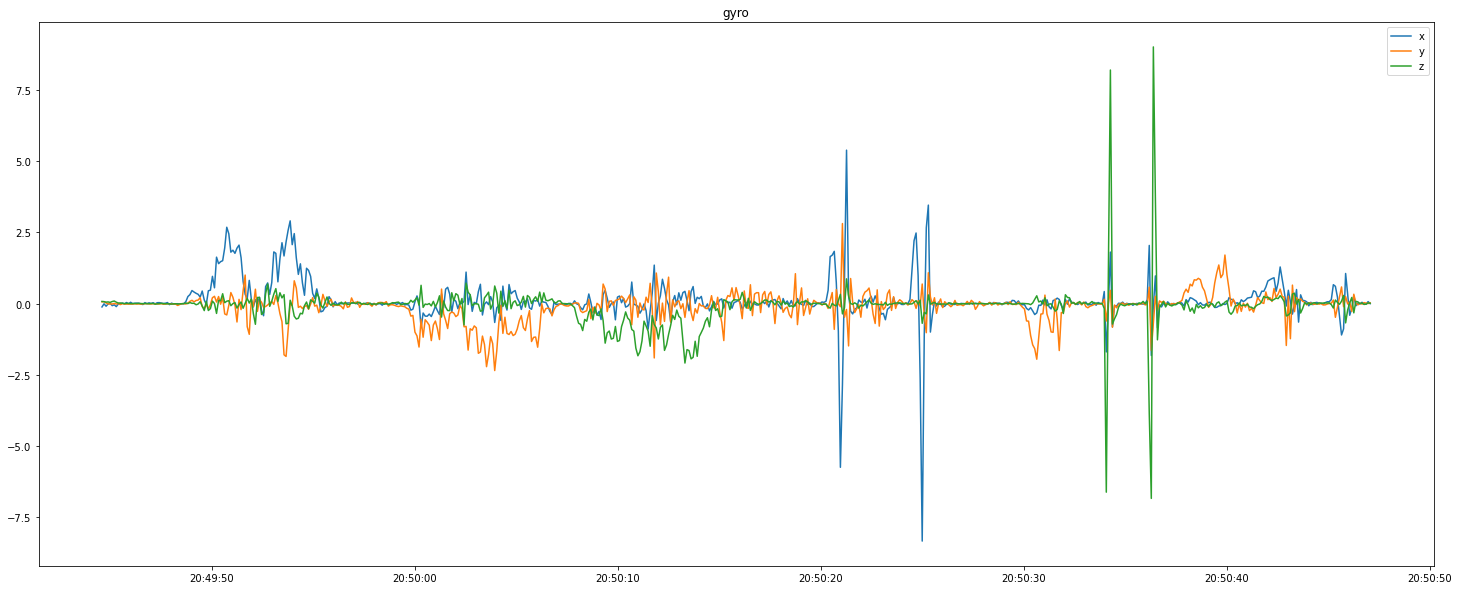

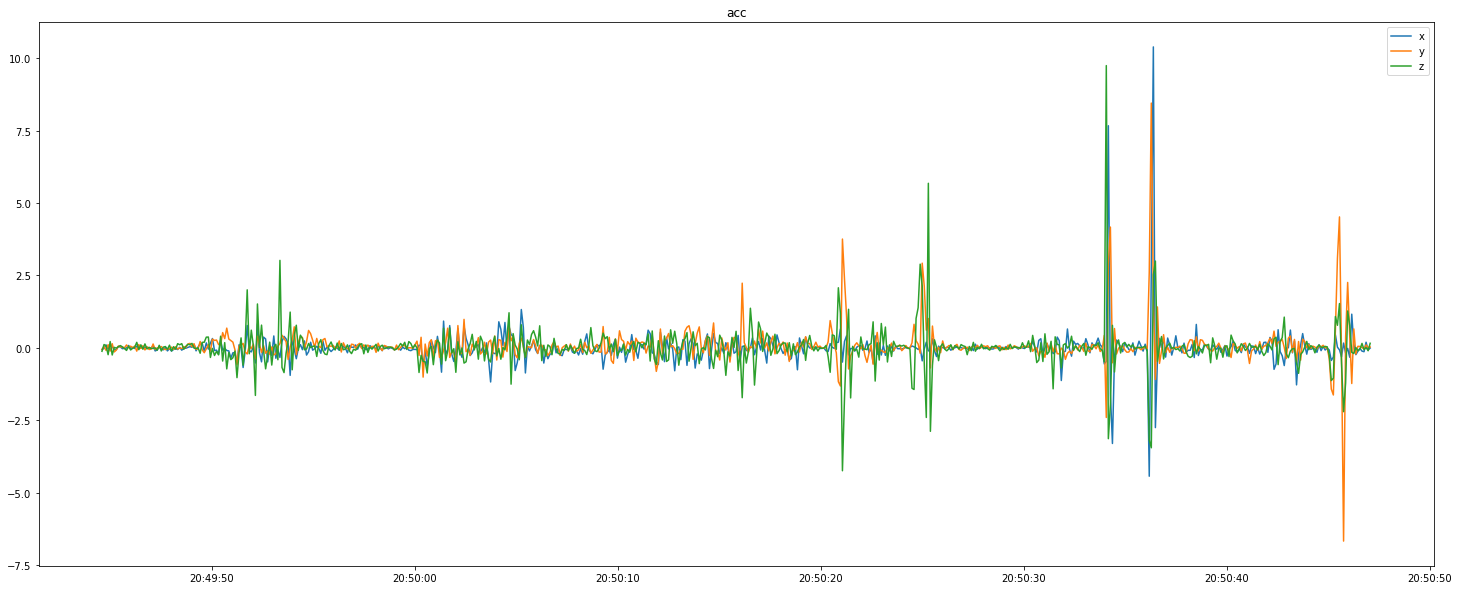

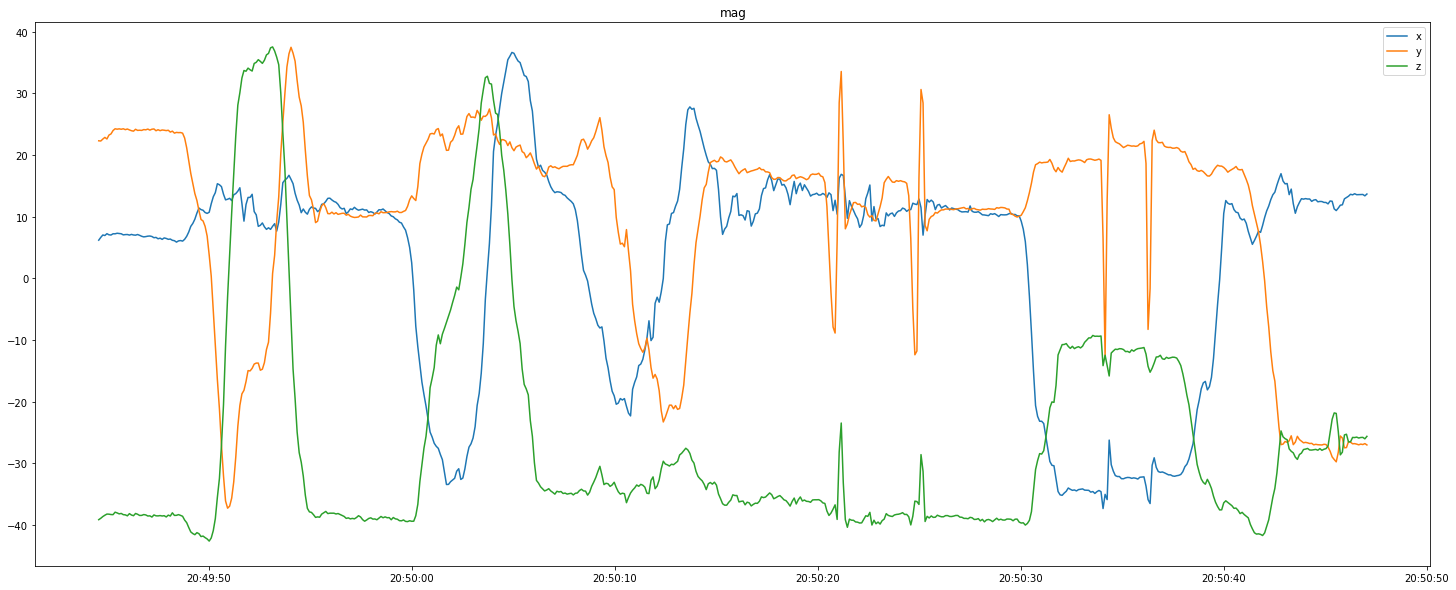

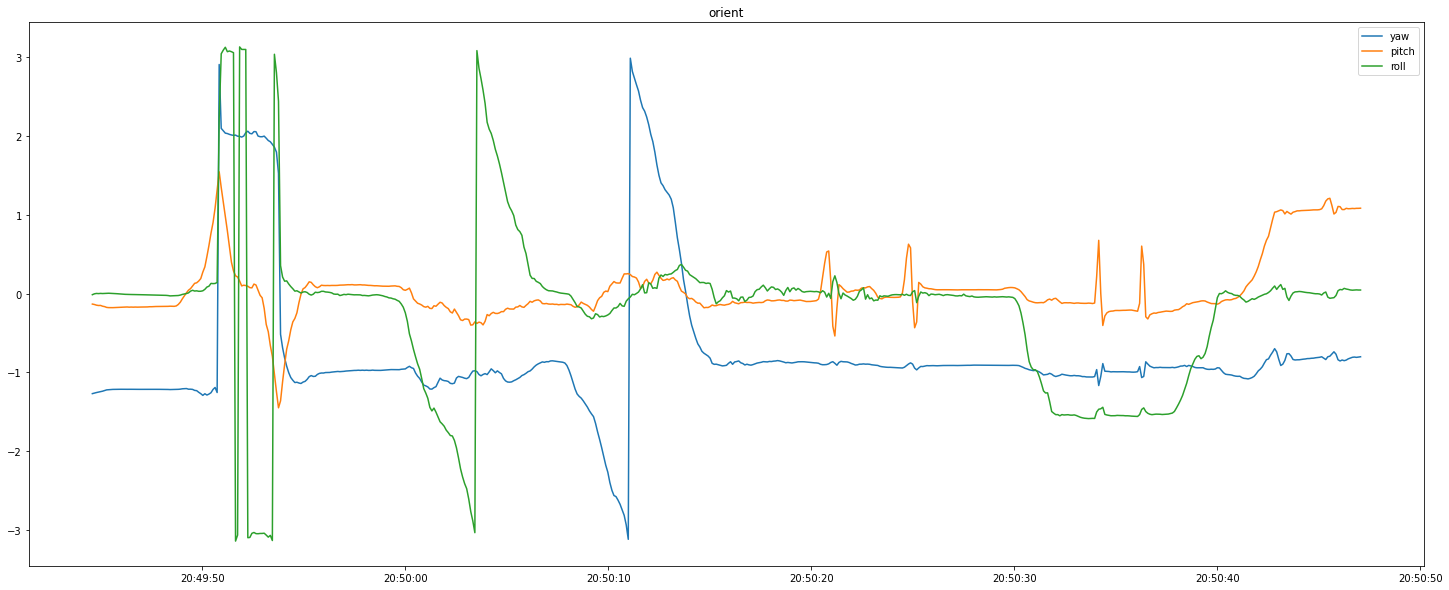

In [7]:
plotter(gyro, 'gyro')
plotter(acc, 'acc')
plotter(mag, 'mag')
plotter(orient, 'orient')


## data streaming from smartphone

In [8]:
# To log data from the smartphone in realtime an http server was crearted in the file server.py, as well as a realtime plotting script that is present in plotter.py


## Kalman filter 

In [9]:
# We will use the Kalman filter to fuse the readings of gyroscope, accelerometer and magnetometer together in order to detect the smartphone's orientation in realtime.


## The Machine learning model

For the models we will use catboost and random forest.

The model will use the Pitch resulting from fusing the different sensors data to detect road anomalies

In [10]:
# mering all of the data frames present in ./datasets/collected_data/testing_dfs/ into one dataframe

files = os.path.join('./datasets/collected_data/testing_dfs/', '*.csv')
files = glob.glob(files)
dfs = []
for file in files:
    dfs.append(pd.read_csv(file))
df = pd.concat(dfs, ignore_index=True)
df = time_fixer(df)
df = df.sort_values(by=['time'])
df.reset_index(drop=True, inplace=True)
df['label'] = "normal"
df.head()



,time,seconds_elapsed,yaw,qx,qz,roll,qw,qy,pitch,label
0,2022-11-30 12:38:45.140398600,0.138399,-0.592421,0.125901,-0.292808,-0.058488,0.945354,-0.068691,0.281992,normal
1,2022-11-30 12:38:45.241190400,0.239190,-0.588544,0.120493,-0.291647,-0.068710,0.946165,-0.072074,0.273449,normal
2,2022-11-30 12:38:45.341982500,0.339982,-0.583900,0.121460,-0.289676,-0.072594,0.946496,-0.074035,0.276318,normal
3,2022-11-30 12:38:45.442774500,0.440774,-0.586405,0.134550,-0.289550,-0.054073,0.945176,-0.068546,0.298454,normal
4,2022-11-30 12:38:45.543566600,0.541567,-0.586898,0.132628,-0.289676,-0.051847,0.945530,-0.066863,0.293751,normal


## Data Labeling

In [11]:
# df = labeler(df, '2022-11-27 12:17:42', '2022-11-27 12:17:46', 'bump')
# df = labeler(df, '2022-11-27 12:20:14', '2022-11-27 12:20:18', 'bump')
df = labeler(df, '2022-11-30 12:42:10', '2022-11-30 12:42:14', 'bump')
df = labeler(df, '2022-11-30 12:44:30', '2022-11-30 12:44:34', 'bump')
df = labeler(df, '2022-12-03 20:33:45', '2022-12-03 20:33:49', 'bump')
df = labeler(df, '2022-12-03 20:34:22', '2022-12-03 20:34:26', 'bump')
df = labeler(df, '2022-12-03 20:35:26', '2022-12-03 20:35:30', 'bump')
df = labeler(df, '2022-12-03 20:35:52', '2022-12-03 20:35:56', 'bump')
df = labeler(df, '2022-12-03 20:36:24', '2022-12-03 20:36:28', 'bump')
df = labeler(df, '2022-12-03 20:37:05', '2022-12-03 20:37:09', 'bump')
df = labeler(df, '2022-12-03 20:37:21', '2022-12-03 20:37:25', 'bump')
df = labeler(df, '2022-12-03 20:37:52', '2022-12-03 20:37:56', 'bump')
df = labeler(df, '2022-12-03 20:48:21', '2022-12-03 20:48:25', 'bump')
df = labeler(df, '2022-12-03 20:48:33', '2022-12-03 20:48:37', 'bump')
df = labeler(df, '2022-12-03 20:48:44', '2022-12-03 20:48:48', 'bump')
df = labeler(df, '2022-12-03 20:49:04', '2022-12-03 20:49:08', 'bump')
df = labeler(df, '2022-12-03 20:49:30', '2022-12-03 20:49:34', 'bump')
df = labeler(df, '2022-12-03 20:50:19', '2022-12-03 20:50:23', 'bump')
df = labeler(df, '2022-12-03 20:51:05', '2022-12-03 20:51:09', 'bump')
df = labeler(df, '2022-12-03 20:51:35', '2022-12-03 20:51:39', 'bump')
df = labeler(df, '2022-12-03 20:55:45', '2022-12-03 20:55:49', 'bump')
df = labeler(df, '2022-12-03 20:56:21', '2022-12-03 20:56:25', 'bump')
df = labeler(df, '2022-12-03 20:57:23', '2022-12-03 20:57:27', 'bump')
df = labeler(df, '2022-12-03 21:00:02', '2022-12-03 21:00:06', 'bump')
df = labeler(df, '2022-12-03 21:00:36', '2022-12-03 21:00:40', 'bump')
df = labeler(df, '2022-12-03 21:01:38', '2022-12-03 21:01:42', 'bump')

df.head()

,time,seconds_elapsed,yaw,qx,qz,roll,qw,qy,pitch,label
0,2022-11-30 12:38:45.140398600,0.138399,-0.592421,0.125901,-0.292808,-0.058488,0.945354,-0.068691,0.281992,normal
1,2022-11-30 12:38:45.241190400,0.239190,-0.588544,0.120493,-0.291647,-0.068710,0.946165,-0.072074,0.273449,normal
2,2022-11-30 12:38:45.341982500,0.339982,-0.583900,0.121460,-0.289676,-0.072594,0.946496,-0.074035,0.276318,normal
3,2022-11-30 12:38:45.442774500,0.440774,-0.586405,0.134550,-0.289550,-0.054073,0.945176,-0.068546,0.298454,normal
4,2022-11-30 12:38:45.543566600,0.541567,-0.586898,0.132628,-0.289676,-0.051847,0.945530,-0.066863,0.293751,normal


## Preprocessing the data to prepare it for the models

The models will try to differentiate between the two classes

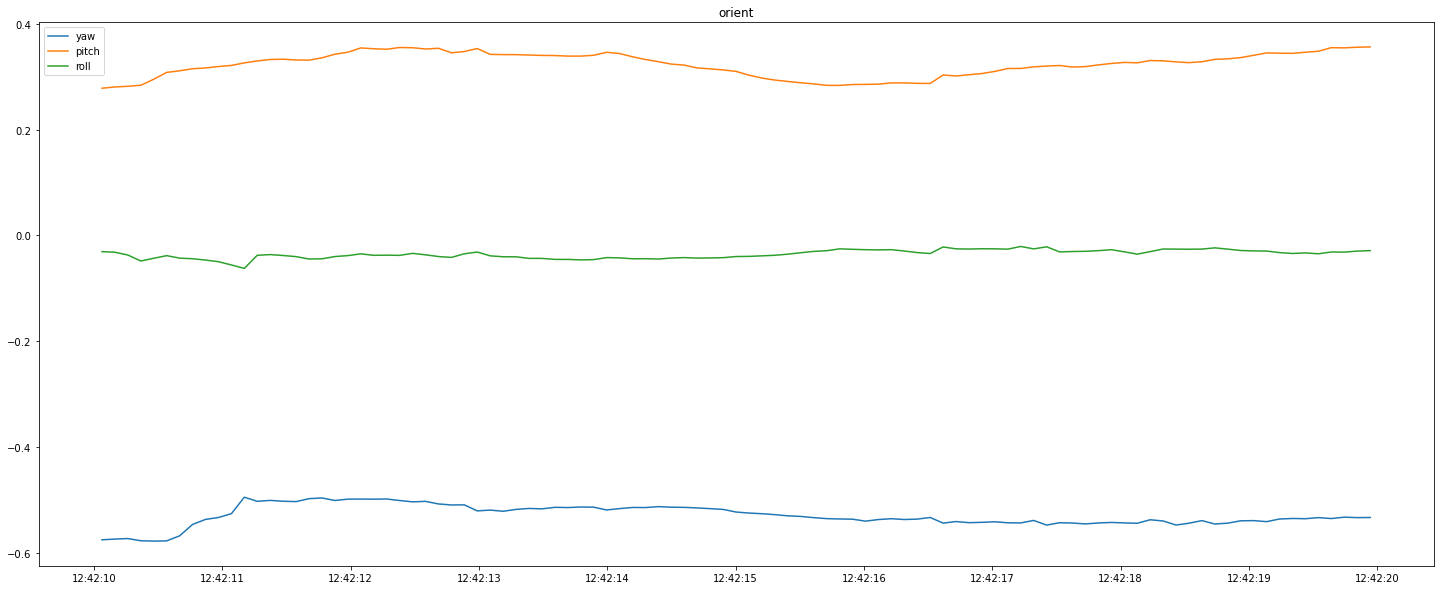

In [12]:
# To confirm the observation that the pitch is the most affected by a road anomaly let's plot the pitch of the smartphone in the time interval of a bump
# according to the collected data the a bump occured at 2022-11-27 between 12:17:42 and 12:17:46, which is clearly visible in the plot below

test_df = df.query('time > "2022-11-30 12:42:10" and time < "2022-11-30 12:42:20"')
plotter(test_df, 'orient')



In [13]:
# now lets segment the dataframe into segments of 4 seconds each and plot the pitch of each segment

segments = segmenter(df, 10)
# sorting the dataframe according to start_time
segments = segments.sort_values(by=['start_time'])
segments.head()

,start_time,end_time,roll_var,pitch_var,yaw_var,roll_mean,pitch_mean,yaw_mean,roll_std,ptich_std,yaw_std,label
0,2022-11-30 12:38:45.140398600,2022-11-30 12:38:47.055450400,0.000056,0.000102,0.000012,-0.053739,0.294887,-0.586647,0.007466,0.010087,0.003437,normal
1,2022-11-30 12:38:47.156242400,2022-11-30 12:38:49.071298800,0.000072,0.000046,0.000315,-0.050429,0.307074,-0.552590,0.008494,0.006817,0.017743,normal
2,2022-11-30 12:38:49.172091000,2022-11-30 12:38:51.087138300,0.000050,0.000060,0.000051,-0.054875,0.283783,-0.499710,0.007042,0.007736,0.007156,normal
3,2022-11-30 12:38:51.187930600,2022-11-30 12:38:53.102982000,0.000050,0.000031,0.000031,-0.042510,0.287449,-0.504111,0.007040,0.005541,0.005573,normal
4,2022-11-30 12:38:53.203774000,2022-11-30 12:38:55.118827300,0.000121,0.000077,0.000002,-0.051022,0.284117,-0.510650,0.011020,0.008753,0.001318,normal


In [14]:
# plotting a heatmap representing the correlation between the different features of the smartphone's orientation

segments.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 0 to 1605
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_time  1606 non-null   datetime64[ns]
 1   end_time    1606 non-null   datetime64[ns]
 2   roll_var    1606 non-null   float64       
 3   pitch_var   1606 non-null   float64       
 4   yaw_var     1606 non-null   float64       
 5   roll_mean   1606 non-null   float64       
 6   pitch_mean  1606 non-null   float64       
 7   yaw_mean    1606 non-null   float64       
 8   roll_std    1606 non-null   float64       
 9   ptich_std   1606 non-null   float64       
 10  yaw_std     1606 non-null   float64       
 11  label       1606 non-null   string        
dtypes: datetime64[ns](2), float64(9), string(1)
memory usage: 163.1 KB


## Correlation analysis

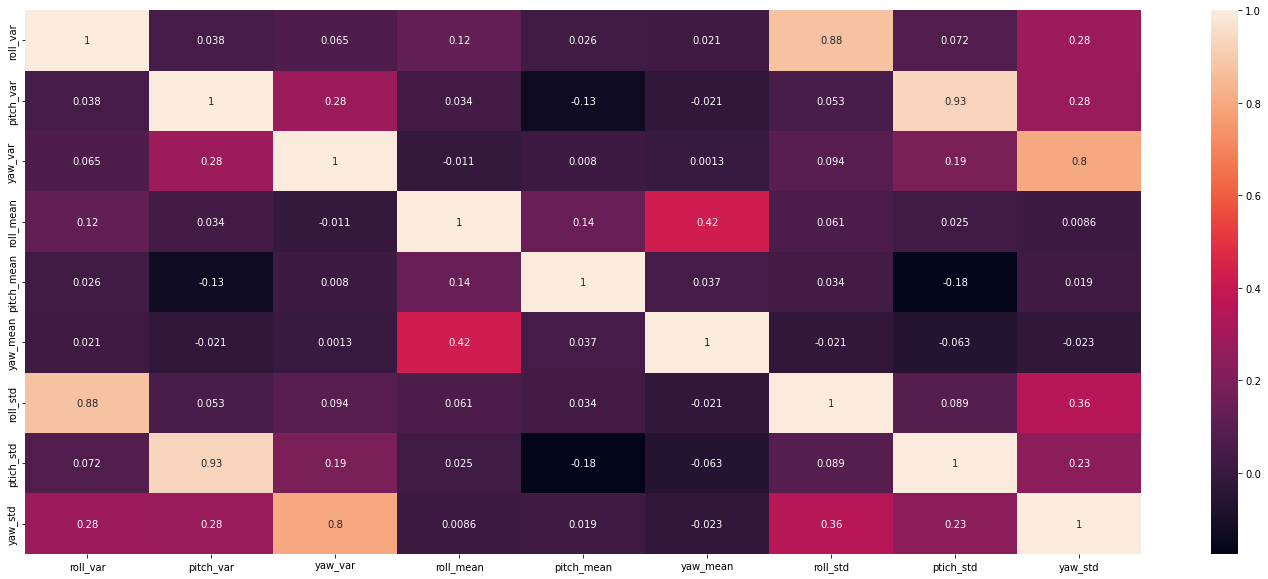

In [15]:
# plotting a heatmap denoting the correlation between the different features of the smartphone's orientation
plt.figure(figsize=(25, 10))
sns.heatmap(segments.corr(), annot=True,)
plt.show()


In [16]:
# We will study the point biserial correlation between the label and the different features of the smartphone's orientation
# but first we will need to encode the label column

point_bisrial_df = segments.copy()
point_bisrial_df['label'] = point_bisrial_df['label'].map({'normal': 0, 'bump': 1})

# now that the label column has been encoded we can explore the point biserial correlation between the label and the different features of the smartphone's orientation
for i in point_bisrial_df.columns:
    if i != 'label' and i != 'start_time' and i != 'end_time':
        print(i, stats.pointbiserialr(point_bisrial_df['label'], point_bisrial_df[i]), '\n')


roll_var PointbiserialrResult(correlation=0.020142337012854294, pvalue=0.41986465577005705) 

pitch_var PointbiserialrResult(correlation=0.30714225728563804, pvalue=1.9808403085811174e-36) 

yaw_var PointbiserialrResult(correlation=-0.013636272619245882, pvalue=0.5850160561417946) 

roll_mean PointbiserialrResult(correlation=-0.038312126357438116, pvalue=0.12485169297032114) 

pitch_mean PointbiserialrResult(correlation=-0.03936405460503107, pvalue=0.11481977281442703) 

yaw_mean PointbiserialrResult(correlation=-0.029330475623278878, pvalue=0.24009303202848983) 

roll_std PointbiserialrResult(correlation=0.02975539792859419, pvalue=0.23334716244157996) 

ptich_std PointbiserialrResult(correlation=0.2987656562561237, pvalue=1.799657697762714e-34) 

yaw_std PointbiserialrResult(correlation=-0.017759791107640005, pvalue=0.4769452415305005) 



## Testing

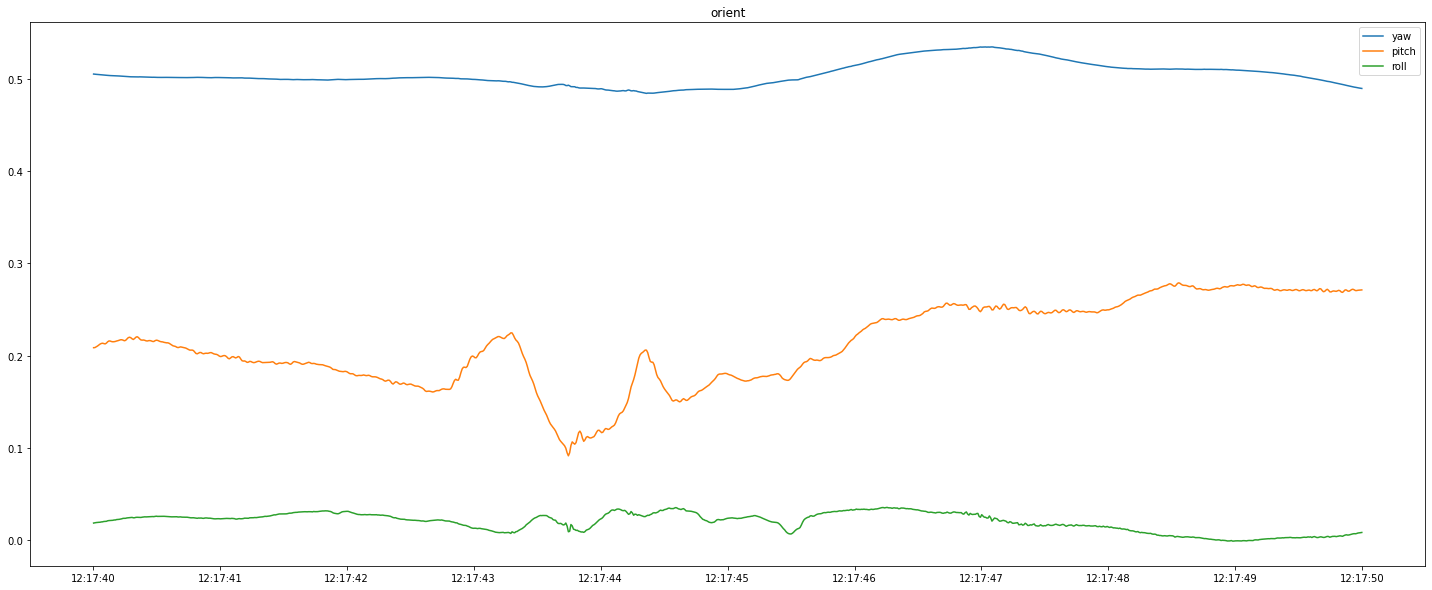

In [17]:
df2 = pd.read_csv('./datasets/collected_data/testing_dfs/tester/Orientation.csv')
df2['label'] = "normal"
df2 = time_fixer(df2)
df2 = df2.sort_values(by=['time'])
df2 = df2.reset_index(drop=True)
df2 = labeler(df2, '2022-11-27 12:17:42', '2022-11-27 12:17:46', 'bump')
df2 = labeler(df2, '2022-11-27 12:20:14', '2022-11-27 12:20:18', 'bump')
test_df = df2.query('time > "2022-11-27 12:17:40" and time < "2022-11-27 12:17:50"')
plotter(test_df, 'orient')


In [18]:
segments = segmenter(df2, 100)
segments = segments.sort_values(by=['start_time'])

point_bisrial_df = segments.copy()
point_bisrial_df['label'] = point_bisrial_df['label'].map({'normal': 0, 'bump': 1})

# now that the label column has been encoded we can explore the point biserial correlation between the label and the different features of the smartphone's orientation
for i in point_bisrial_df.columns:
    if i != 'label' and i != 'start_time' and i != 'end_time':
        print(i, stats.pointbiserialr(point_bisrial_df['label'], point_bisrial_df[i]), '\n')


roll_var PointbiserialrResult(correlation=0.06769865800598296, pvalue=0.35855799725119386) 

pitch_var PointbiserialrResult(correlation=0.7910297132395099, pvalue=4.004948291783527e-41) 

yaw_var PointbiserialrResult(correlation=0.4467981938139711, pvalue=1.6320875428751828e-10) 

roll_mean PointbiserialrResult(correlation=0.08033656909559828, pvalue=0.2757036756804343) 

pitch_mean PointbiserialrResult(correlation=-0.18127278916866324, pvalue=0.01328211339121011) 

yaw_mean PointbiserialrResult(correlation=-0.3535558376089312, pvalue=7.41477545592928e-07) 

roll_std PointbiserialrResult(correlation=0.12130578075572555, pvalue=0.09907921927965918) 

ptich_std PointbiserialrResult(correlation=0.6499965396710015, pvalue=1.0375011175936083e-23) 

yaw_std PointbiserialrResult(correlation=0.38068976719186887, pvalue=8.316432516212065e-08) 

